In [1]:
import os
import time
import csv
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.main import sonnmf
from sonnmf.old.main import sonnmf as sonnmf_old
import matplotlib.pyplot as plt

In [2]:
def sample_dirichlet(alpha, N):
    k = len(alpha)
    theta = np.zeros((N, k))
    scale = 1
    for i in range(k):
        theta[:, i] = np.random.gamma(alpha[i], scale, N)
    S = np.sum(theta, axis=1)
    theta = theta / np.tile(S.reshape(-1, 1), (1, k))
    return theta


def create_synthetic_data():
    Wt = np.array([[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1]])
    r = 4

    n = 500
    purity = 0.8
    alpha = 0.05 * np.ones((r, 1))
    Ht = sample_dirichlet(alpha, n).T
    for j in range(n):
        while np.max(Ht[:, j]) > purity:
            Ht[:, j: j+1] = sample_dirichlet(alpha, 1).T
    epsilon = 0.01
    Xt = np.dot(Wt, Ht)
    X = np.maximum(0, Xt + epsilon * np.random.randn(*Xt.shape))
    return X, Wt, Ht

def plot_3d(X, Wt, W, ax=None, legend=None):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    if legend:
        ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)

# def plot_3d(X, Wt, W, filepath=None):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
#     ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
#     ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
#     ax.set_xlabel('X1')
#     ax.set_ylabel('X2')
#     ax.set_zlabel('X3')
#     ax.legend(['Data points', 'True W', 'Estimated W'])
#     ax.grid(True)
#     plt.tight_layout()
#     if filepath:
#         plt.savefig(filepath)
#     else:
#         plt.show()
#     plt.close()

def save_results(filepath, W, H, fscores, gscores, hscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

In [3]:
data_filepath = '../datasets/synthetic_data.npz'
saved_model_filepath = '../saved_models/synthetic/'

### Creating synthetic data

In [4]:
if os.path.exists(data_filepath):
    data = np.load(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']
else:
    M, W_true, H_true = create_synthetic_data()
    with open(data_filepath, 'wb') as fout:
        np.savez_compressed(fout, M=M, W_true=W_true, H_true=H_true)

In [5]:
m, n = M.shape

### Synthetic data experiment 1, rank = 4

In [6]:
r = 4
max_iters = 1000
_lam = 1e-6 
_gamma = 10

In [7]:
ini_filepath = saved_model_filepath + f'r{r}_ini.npz'
if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

Vanilla NMF

In [8]:
save_filepath = saved_model_filepath + f'vanilla_r{r}_it{max_iters}.npz'
if os.path.exists(save_filepath):
    data = np.load(save_filepath)
    W = data['W']
    H = data['H']
else:
    model = NMF(n_components=r, init='custom', random_state=42, max_iter=max_iters)
    W = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
    H = model.components_
    with open(save_filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H)

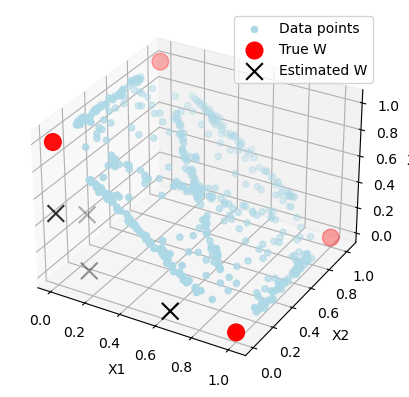

In [9]:
plot_3d(M, W_true, W, legend=['Data points', 'True W', 'Estimated W'])

SONNMF

In [10]:
save_filepath = saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz'

if os.path.exists(save_filepath):
    W, H, fscores, gscores, hscores, total_scores = load_results(save_filepath)
else:
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

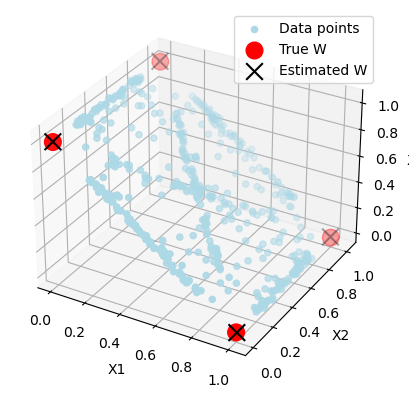

In [11]:
plot_3d(M, W_true, W, legend=['Data points', 'True W', 'Estimated W'])

### Synthetic data experiment 1, rank = 8

In [12]:
r = 8
max_iters = 1000
_lam = 1e-6 
_gamma = 1.5

In [13]:
ini_filepath = saved_model_filepath + f'r{r}_ini.npz'
if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

Vanilla NMF

In [14]:
save_filepath = saved_model_filepath + f'vanilla_r{r}_it{max_iters}.npz'
if os.path.exists(save_filepath):
    data = np.load(save_filepath)
    W = data['W']
    H = data['H']
else:
    model = NMF(n_components=r, init='custom', random_state=42, max_iter=max_iters)
    W = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
    H = model.components_
    with open(save_filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H)

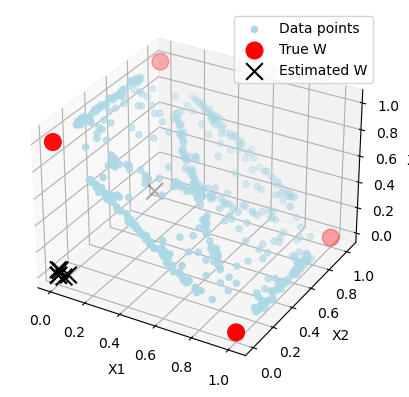

In [15]:
plot_3d(M, W_true, W, legend=['Data points', 'True W', 'Estimated W'])

SONNMF

In [16]:
save_filepath = saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz'

if os.path.exists(save_filepath):
    W, H, fscores, gscores, hscores, total_scores = load_results(save_filepath)
else:
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

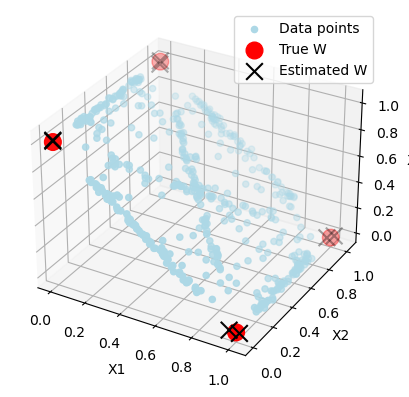

In [17]:
plot_3d(M, W_true, W, legend=['Data points', 'True W', 'Estimated W'])

### Creating plots for article

Comparing SONNMF to vanilla NMF

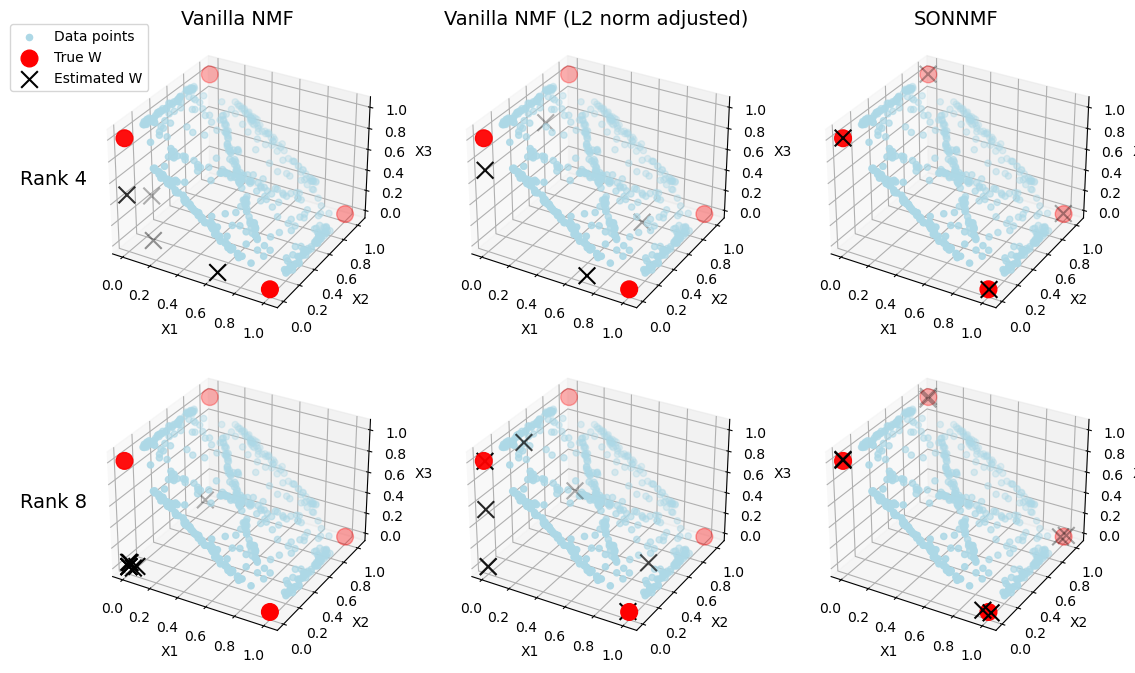

In [18]:
row_labels = ['Rank 4', 'Rank 8']
col_labels = ['Vanilla NMF', 'Vanilla NMF (L2 norm adjusted)', 'SONNMF']

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, len(col_labels) + 1, width_ratios=[0.02] + len(col_labels) * [1], hspace=0.1)

for i, rlabel in enumerate(row_labels):
    txt_ax = fig.add_subplot(gs[i, 0])
    txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=14)
    txt_ax.axis('off')


r = 4
_lam = 1e-6
_gamma = 10
max_iters = 1000

vW1 = np.load(saved_model_filepath + f'vanilla_r{r}_it{max_iters}.npz')['W']
col_norm_vW1 = np.linalg.norm(vW1, axis=0, ord=2, keepdims=True)
vW1_re = vW1 / (col_norm_vW1 + 1e-12)
cW1, _, _, _, _, _ = load_results(saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

for i, curr_W in enumerate([vW1, vW1_re, cW1]):
    curr_subplot = fig.add_subplot(gs[0, i+1], projection='3d')
    plot_3d(M, W_true, curr_W, ax=curr_subplot)
    curr_subplot.set_title(col_labels[i], fontsize=14)


r = 8
_lam = 1e-6
_gamma = 1.5

vW2 = np.load(saved_model_filepath + f'vanilla_r{r}_it{max_iters}.npz')['W']
col_norm_vW2 = np.linalg.norm(vW2, axis=0, ord=2, keepdims=True)
vW2_re = vW2 / (col_norm_vW2 + 1e-12)
cW2, _, _, _, _, _ = load_results(saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

for i, curr_W in enumerate([vW2, vW2_re, cW2]):
    plot_3d(M, W_true, curr_W, ax=fig.add_subplot(gs[1, i+1], projection='3d'))
fig.legend(['Data points', 'True W', 'Estimated W'],
                 bbox_to_anchor=(0.2, 0.9, 0, 0))
fig.subplots_adjust(wspace=0)
plt.savefig('../image_pdfs/synthetic_vanilla_vs_sonnmf.pdf', bbox_inches='tight')

Comparing SONMF W solver ProxAvg to other W solvers (ADMM, Nesterov Smoothing)

In [19]:
def save_results_old(filepath, W, H, fscores, gscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, total_scores=total_scores)

def load_results_old(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['total_scores']

In [20]:
r = 8
max_iters = 1000
_lam = 1e-6 
_gamma = 1.5

In [21]:
csv_filename = "runtime_results.csv"

if not os.path.exists(csv_filename):
    with open(csv_filename, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Dataset' ,'Method', 'Time Taken', 'Save Filepath'])

In [22]:
# ProxAvg

save_filepath = saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}_proxavg.npz'

start_time = time.time()
W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, max_minutes=600, W_update_iters=10, early_stop=True, verbose=False)
time_taken = time.time() - start_time
save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

with open(csv_filename, 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['sythetic_r8' , 'proxavg', time_taken, save_filepath])

In [24]:
# ADMM

save_filepath = saved_model_filepath + f'r{r}_l{_lam}_it{max_iters}_admm.npz'

start_time = time.time()
W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=_lam, w_update_method='admm', itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
time_taken = time.time() - start_time
save_results_old(save_filepath, W, H, fscores, gscores, total_scores)

with open(csv_filename, 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['sythetic_r8' , 'admm', time_taken, save_filepath])

In [25]:
# Nesterov's smoothing

save_filepath = saved_model_filepath + f'r{r}_l{_lam}_it{max_iters}_nesterov.npz'

start_time = time.time()
W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=_lam, w_update_method='nesterov_smoothing', itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
time_taken = time.time() - start_time
save_results_old(save_filepath, W, H, fscores, gscores, total_scores)

with open(csv_filename, 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['sythetic_r8' , 'nesterov_smoothing', time_taken, save_filepath])

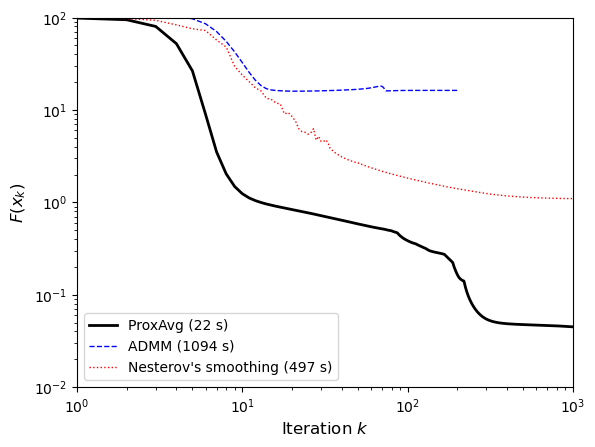

In [44]:
_, _, fscores, gscores, _, total_scores = load_results(saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}_proxavg.npz')
total_scores = fscores + _lam * gscores
plt.plot(total_scores, 'k-', linewidth=2) 

_, _, fscores, gscores, total_scores = load_results_old(saved_model_filepath + f'r{r}_l{_lam}_it{max_iters}_admm.npz')
plt.plot(total_scores, 'b--', linewidth=1)

_, _, fscores, gscores, total_scores = load_results_old(saved_model_filepath + f'r{r}_l{_lam}_it{max_iters}_nesterov.npz')
plt.plot(total_scores, 'r:', linewidth=1)

plt.xlim((1, 1000))
plt.ylim((10**-2, 10**2))
plt.xscale('log')
plt.yscale('log')
plt.legend(['ProxAvg (22 s)', 'ADMM (1094 s)', 'Nesterov\'s smoothing (497 s)'])
plt.xlabel('Iteration $k$', fontsize=12)
plt.ylabel('$F(x_k)$', fontsize=12)

plt.savefig(f'../image_pdfs/synthetic_r8_solvers_comparison.pdf', bbox_inches='tight')
